## Calibrate camera

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

# Custom code
from calibrate import *

%matplotlib inline

## Load images

In [2]:
import re

def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])

    return parts

# Make a list of calibration images
calib_images_path = sorted(glob.glob('./camera_cal/calibration*.jpg'), key=numericalSort)

# Make a list of test images
test_images = [(path, mpimage.imread(path)) for path in 
               sorted(glob.glob('./test_images/test*.jpg'), key=numericalSort)]
# test_images = [(path, mpimage.imread(path)) for path in 
#                sorted(glob.glob('./capture/challenge*.jpg'), key=numericalSort)]

## Calibrate the camera

In [3]:
mtx, dist, _ = calibrate_camera(calib_images_path)

## Demo undistorted image

#### Undistortion sample (Calibration image)

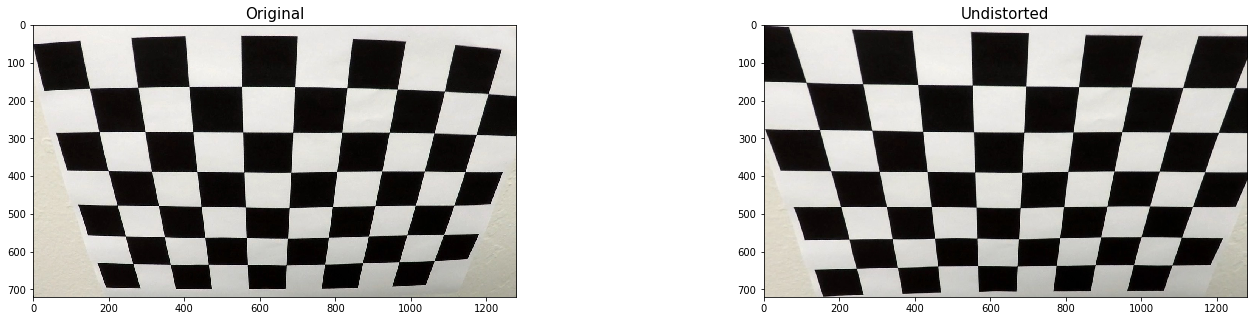

In [4]:
calib_image = mpimage.imread(calib_images_path[1])
undistorted = undistort(calib_image, mtx, dist)

from demo import *
demo([calib_image, undistorted], ["Original", "Undistorted"], 1, 2, save_as="output_images/undistort_output.jpg")

#### Undistortion sample (Test image)

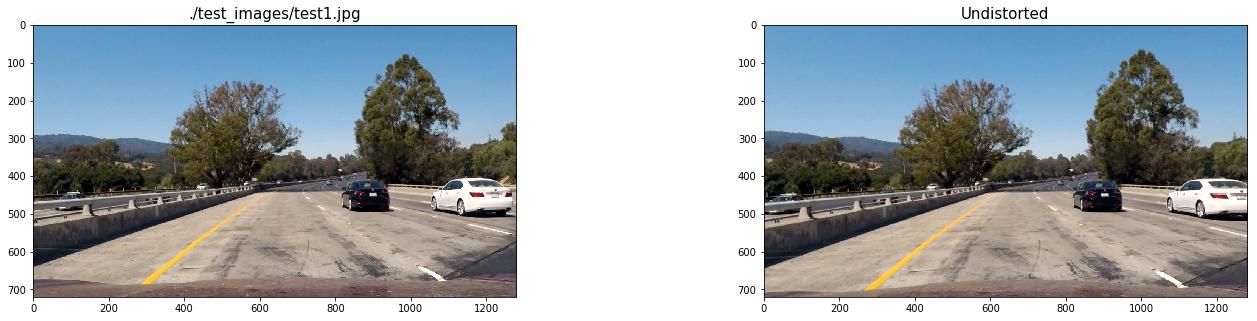

In [5]:
test_image = test_images[0]
undistorted = undistort(test_image[1], mtx, dist)

demo([test_image[1], undistorted], [test_image[0], "Undistorted"], 1, 2, save_as="output_images/undistort_output2.jpg")

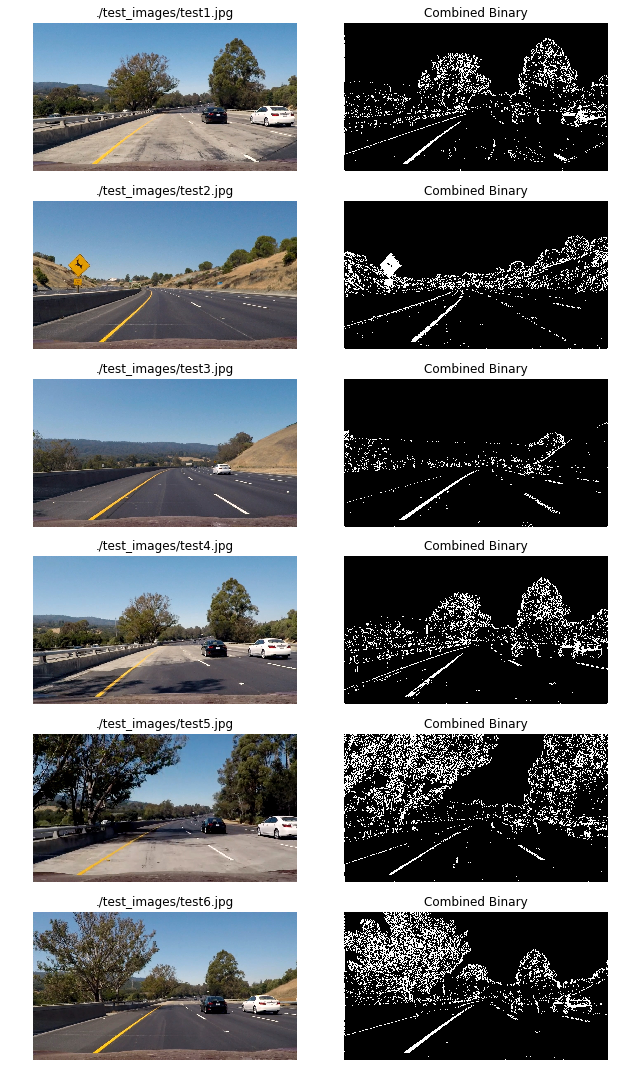

In [6]:
from transform import *

def demo_pipeline(images):    
    f, axis = plt.subplots(6, 2, figsize=(8, 16))
    axis = axis.ravel()
    f.tight_layout()

    for i in range(0, len(images)):
        image = images[i][1]
        binary = pipeline(image)
    
        axis[i*2].axis('off')
        axis[i*2].imshow(image)
        axis[i*2].set_title(images[i][0], fontsize=12)

        axis[i*2+1].axis('off')
        axis[i*2+1].imshow(binary, cmap='gray')
        axis[i*2+1].set_title('Combined Binary', fontsize=12)    
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

demo_pipeline(test_images)

In [7]:
def draw_border(img, points):
    corners = [tuple(p) for p in points]
    cv2.line(img, corners[0], corners[1], color=[255,0,0], thickness=3)
    cv2.line(img, corners[1], corners[2], color=[255,0,0], thickness=3)
    cv2.line(img, corners[2], corners[3], color=[255,0,0], thickness=3)
    cv2.line(img, corners[3], corners[0], color=[255,0,0], thickness=3)

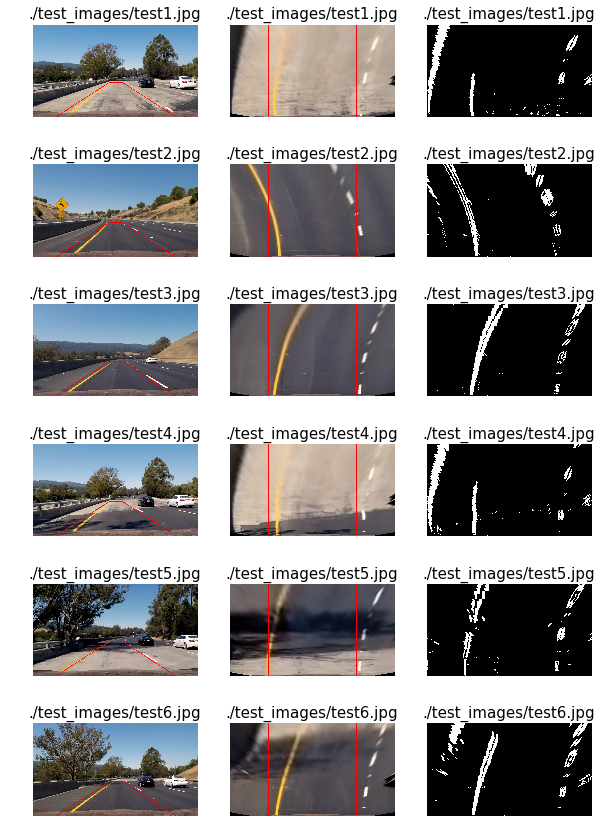

In [8]:
def demo_birds_eye_view(images, mtx, dist):
    r, c = len(images), 3
    f, axis = plt.subplots(r, c, figsize=(10,15))    
    
    axis = axis.ravel()
    
    for i in range(0, len(images)):
        title, img = images[i]
        img = np.copy(img)
        
        binary = pipeline(img)
        
        warped, M, Minv, src, dst = birds_eye_view(img, mtx, dist)        
        binary_warped, M, Minv, src, dst = birds_eye_view(binary, mtx, dist)
        
        draw_border(img, src)
        draw_border(warped, dst)
        
        axis[i*c].axis('off')      
        axis[i*c].imshow(img)
        axis[i*c].set_title(title, fontsize=15)

        axis[i*c+1].axis('off')      
        axis[i*c+1].imshow(warped, cmap='gray')
        axis[i*c+1].set_title(title, fontsize=15)

        axis[i*c+2].axis('off')      
        axis[i*c+2].imshow(binary_warped, cmap='gray')
        axis[i*c+2].set_title(title, fontsize=15)        
    plt.show()
    
demo_birds_eye_view(test_images, mtx, dist)

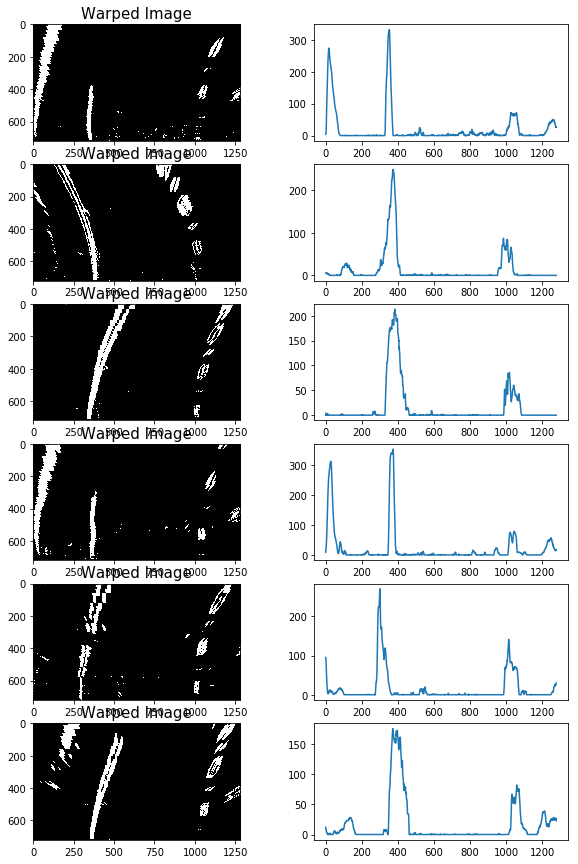

In [9]:
import numpy as np

def demo_histogram(images):
    r, c = len(images), 2
    f, axis = plt.subplots(r, c, figsize=(10,15))    
    
    axis = axis.ravel()
    
    for i in range(0, len(images)):
        title, img = images[i]
        img = np.copy(img)
        
        binary = pipeline(img)
        binary_warped, _,_,_,_ = birds_eye_view(binary, mtx, dist)
    
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
         
        axis[i*c].imshow(binary_warped, cmap='gray')
        axis[i*c].set_title('Warped Image', fontsize=15)

        axis[i*c+1].plot(histogram)       
    plt.show()
    
demo_histogram(test_images)

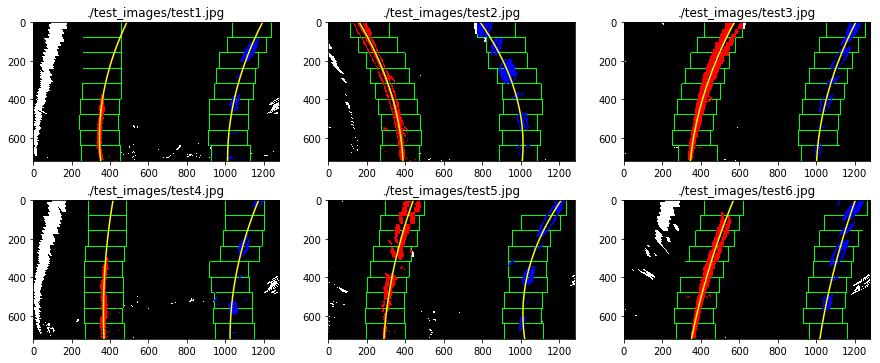

In [10]:
from lane import *

def demo_lane_search(images):
    r, c = int(len(images)/3), 3
    f, axis = plt.subplots(r, c, figsize=(15,6))    
    
    axis = axis.ravel()
    
    for i in range(0, len(images)):
        title, img = images[i]
        binary = pipeline(img)
        binary_warped, _,_,_,_ = birds_eye_view(binary, mtx, dist)

        left_line = Line()
        right_line = Line()
       
        left_fit, right_fit, out_img = get_lanes(binary_warped, left_line, right_line)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])    
        
        axis[i].set_title(title)
        axis[i].imshow(out_img)
        axis[i].plot(left_fitx, ploty, color='yellow')
        axis[i].plot(right_fitx, ploty, color='yellow')
        axis[i].set_xlim(0, 1280)
        axis[i].set_ylim(720, 0)
    plt.show()
       

demo_lane_search(test_images)

In [11]:
left_line = Line()
right_line = Line()
    
def process_image(img):
    binary = pipeline(img)
    binary_warped, _, Minv,_,_ = birds_eye_view(binary, mtx, dist)

    left_fit, right_fit, out_img = get_lanes(binary_warped, left_line, right_line)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    result = draw_lane(img, binary_warped, Minv, left_fit, right_fit, ploty)

    return result

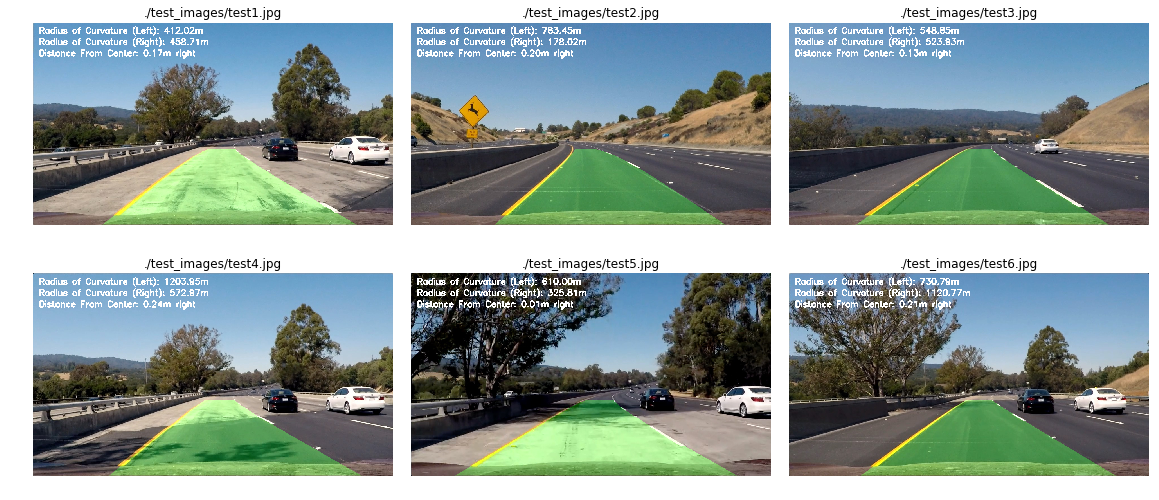

In [12]:
def demo_process_image(images):
    f, axis = plt.subplots(2, 3, figsize=(20,9))
    f.subplots_adjust(hspace = .05, wspace=.05)
    
    axis = axis.ravel()    
        
    for i in range(0, len(images)):        
        result = process_image(images[i][1])
        
        axis[i].axis('off')      
        axis[i].imshow(result)
        axis[i].set_title(images[i][0], fontsize=12)
    plt.show()
    
demo_process_image(test_images)

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(8,12)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [03:37<00:00,  5.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 12min 12s, sys: 4.42 s, total: 12min 17s
Wall time: 3min 38s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))